
## ECON 8185 - Homework Assignment 1

#### Xiang Liu
#### Email: liu01246@umn.edu
#### ID: 5596987
#### I gained help from Yuta, Byungho, Jason. 

In [23]:
#  Begin by adding the packages Interpolations, Optim
# (e.g., https://www.educative.io/answers/how-to-install-julia-packages-via-command-line)
#

# install packages:

# import Pkg
# Pkg.add.(["Interpolations","Optim", "PyPlot", "LaTeXStrings"])

In [24]:
using Interpolations, Optim

In [25]:
"""
A function that provides linear interpolation with constant extrapolation
outside the bounds.

    x : a linear grid of interpolation points
    fx : the values of the function on the grid points

"""
function lin_interp(x, fx)
    return linear_interpolation(x, fx, 
                extrapolation_bc = Interpolations.Flat())
end

lin_interp

In [26]:
"""
Create an instance of the model, stored as a namedtuple.

"""
function create_opt_savings_model(; β=0.9,      # Discount factor
                                    γ=2.0,      # CRRA utility parameter
                                    R=1.2,      # Gross rate of return
                                    w_size=200, # Grid size for wealth
                                    w_max=10)   # Upper bound for wealth
    w_grid = LinRange(1e-8, w_max, w_size)      # linearly spaced elements between its start and stop, avoid 0 since u(0) is not defined
    u(c) = c^(1 - γ) / (1 - γ)                  # CRRA
    v_init = u.(w_grid)                         # Initial guess as utility value
    return (; β, u, R, w_grid, v_init)
end

create_opt_savings_model

In [27]:
"""
The Bellman operator

    (Tv)(w) = min_{0 ≤ c ≤ w} { u(c) + β v(R(w - c))}

"""
# for VFI
function T(v, model)
    (; β, u, R, w_grid) = model     # Unpacking a paritcular NamedTuple "model"

    v_new = similar(v)              # Create a same-size array as initial guess
    v = lin_interp(w_grid, v)       # Interpolation and extrapolation

    for (i, w) in enumerate(w_grid)
        result = maximize(c -> u(c) + β * v(R * (w - c)), 0.0, w)  # -> ???
        v_new[i] = Optim.maximum(result)
    end

    return v_new
end

T (generic function with 1 method)

In [28]:
" Get a v-greedy policy "
# for optimistic policy iteration (OPI)

function get_greedy(v, model)
    (; β, u, R, w_grid) = model

    σ = similar(v) 
    v = lin_interp(w_grid, v)

    for (i, w) in enumerate(w_grid)
        result = maximize(c -> u(c) + β * v(R * (w - c)), 0.0, w) 
        σ[i] = Optim.maximizer(result)   # maximizer here, that is, c
    end

    return σ
end

get_greedy (generic function with 1 method)

In [29]:
# VFI

function vfi(model;
                tolerance=1e-6,    
                max_iter=10_000,  
                print_step=100)      

k = 0
error = tolerance + 1
v = model.v_init

while (error > tolerance) & (k <= max_iter)
    v_new = T(v, model)
    error = maximum(abs.(v_new - v))
    if k % print_step == 0  # print when k is a factor of print_step
        println("Completed iteration $k with error $error.")
    end
    v = v_new
    k += 1
end

if error <= tolerance
    println("Terminated successfully in $k iterations.")
else
    println("Warning: hit iteration bound.")
end

σ = get_greedy(v, model) 
return σ, v
end



vfi (generic function with 1 method)

In [30]:
"""
The policy operator

    (T_σ v)(w) =  u(σ(w)) + β v[R(w - σ(w))]

"""
function T_σ(v, σ, model)
    (; β, u, R, w_grid) = model

    # Add your code here

    v_new = similar(v)
    v = lin_interp(w_grid, v)

    for (i, w) in enumerate(w_grid)

        # The lifetime value v_σ of policy σ is the unique v that solves
        # v(w) = u(σ(w)) + βv(R(w-σ(w))

        v_new[i] = u(σ[i]) + β * v(R * (w - σ[i]))
    end

    return v_new

end


T_σ

In [31]:
"Approximate lifetime value of policy σ."
function get_value(v_init, σ, m, model) 
    
    # m is the number of T_σ operations or the number of iterations

    # Compute and return T_σ^m v_init

    for i in 1:m
        result = T_σ(v_init, σ, model)
        v_init = result
    end

    return v_init

end

get_value

In [32]:
"Optimistic policy iteration routine."
# Follow the algorithm of OPI here

function opi(model; 
              tolerance=1e-6, 
              max_iter=1_000,
              m=20,
              print_step=100,
              verbose = true)  # use variable 'verbose' to avoid too much printings later
    v = model.v_init

    # Put your code here

    k = 0
    error = tolerance + 1

    while (error > tolerance) & (k <= max_iter)

        σ = get_greedy(v, model)  # local σ
        v_new = get_value(v, σ, m, model) 

        error = maximum(abs.(v_new - v))

        if (k % print_step == 0) & (verbose == true) 
            println("Completed iteration $k with error $error.")
        end
        v = v_new
        k += 1
        
    end
    
    if verbose == true
        if error <= tolerance
            println("Terminated successfully in $k iterations.")
        else
            println("Warning: hit iteration bound.")
        end
    end

    σ = get_greedy(v, model) # global σ
    
    return σ, v

end


opi (generic function with 1 method)

In [33]:
using PyPlot
using LaTeXStrings
fontsize=12

12

In [34]:
model = create_opt_savings_model()    # create an instance
(; β, u, R, w_grid, v_init) = model; 
model

(β = 0.9, u = u, R = 1.2, w_grid = LinRange{Float64}(1.0e-8, 10.0, 200), v_init = [-1.0e8, -19.899996059800777, -9.949999019925096, -6.633332899955585, -4.974999757468762, -3.979999845576006, -3.3166665599805594, -2.842857064881635, -2.4874999406109386, -2.2111110644320995  …  -0.10473684210030194, -0.10418848167102875, -0.10364583332955458, -0.10310880828694997, -0.1025773195849851, -0.10205128204918869, -0.1015306122433439, -0.1010152284253704, -0.1005050505045429, -0.1])

In [35]:
println("Solving via VFI. \n\n")
@timev σ_star, v_star = vfi(model);

Solving via VFI. 




Completed iteration 0 with error 9.000000634421515e7.
Completed iteration 100 with error 2390.5260684490204.
Completed iteration 200 with error 0.06349575519561768.
Completed iteration 300 with error 1.6689300537109375e-6.
Terminated successfully in 306 iterations.
  0.241078 seconds (396.81 k allocations: 25.925 MiB, 72.01% compilation time)
elapsed time (ns):  241078030
gc time (ns):       0
bytes allocated:    27184843
pool allocs:        396584
non-pool GC allocs: 228
minor collections:  0
full collections:   0


In [36]:
# Uncomment next two lines and get it working

println("\n\nSolving via HPI.\n\n")
@timev σ_star_opi, v_star_hpi = opi(model);



Solving via HPI.




Completed iteration 0 with error 7.905810665975548e8.
Terminated successfully in 18 iterations.
  0.071536 seconds (80.13 k allocations: 5.415 MiB, 90.18% compilation time)
elapsed time (ns):  71536279
gc time (ns):       0
bytes allocated:    5678463
pool allocs:        80060
non-pool GC allocs: 67
minor collections:  0
full collections:   0


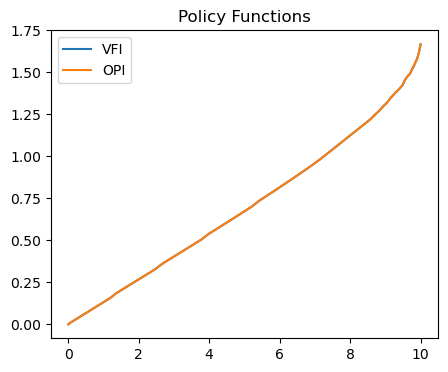

In [37]:
# Plot both policies and check that they are close to each other

fig, ax = plt.subplots(figsize=(5,4))

ax.plot(w_grid, σ_star, label = "VFI")
ax.plot(w_grid, σ_star_opi, label = "OPI")

title("Policy Functions")

ax.legend()
gcf()

In [38]:
# Record the runtime for (a) VFI and (b) OPI at various choices of m
# Plot them to illustrate how OPI compares to VFI 

println("Since VFI does not depend on the value of m, the runtime for this iteration process will be constant")

Since VFI does not depend on the value of m, the runtime for this iteration process will be constant


In [39]:
# Define function to get OPI runtime for different m's

function runtime_opi(model; m_grid = 1:20:1000)
    opi_time = zeros(size(m_grid));
    for (i,m) in enumerate(m_grid)
        # opi_time[i] = @elapsed opi(model; m=m, print_step = 1000);
        opi_time[i] = @elapsed opi(model; m=m, verbose = false);
    end
    return opi_time, m_grid
end

runtime_opi (generic function with 1 method)

In [40]:
opi_time, m_grid = runtime_opi(model);

In [41]:
# VFI runtime:

vfi_time = @elapsed σ_star, v_star = vfi(model);
vfi_time_compiled = ones(size(m_grid)) * vfi_time

Completed iteration 0 with error 9.000000634421515e7.
Completed iteration 100 with error 2390.5260684490204.
Completed iteration 200 with error 0.06349575519561768.


Completed iteration 300 with error 1.6689300537109375e-6.
Terminated successfully in 306 iterations.


50-element Vector{Float64}:
 0.082040486
 0.082040486
 0.082040486
 0.082040486
 0.082040486
 0.082040486
 0.082040486
 0.082040486
 0.082040486
 0.082040486
 ⋮
 0.082040486
 0.082040486
 0.082040486
 0.082040486
 0.082040486
 0.082040486
 0.082040486
 0.082040486
 0.082040486

In [42]:
# Another way to get VFI time:

# vfi_time = @elapsed σ_star, v_star = vfi(model);
# vfi_time_compiled = fill(vfi_time, size(m_grid));

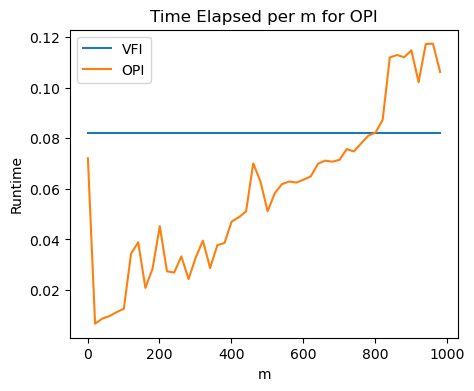

In [43]:
fig, ax = plt.subplots(figsize=(5,4))
ax.plot(m_grid, vfi_time_compiled, label="VFI")
ax.plot(m_grid, opi_time, label="OPI")
title("Time Elapsed per m for OPI")

ax.set_xlabel("m")
ax.set_ylabel("Runtime")

ax.legend()
gcf()